In [ ]:
### Using my developed metrics for nucleiDysmorphia analysis
### Created by Madeline E Melzer on 20230726, Last Edit by Madeline E Melzer on 20230918

In [1]:
import cv2
import glob
import numpy as np
import pandas as pd
import time, os, sys
from urllib.parse import urlparse
import skimage.io
import skimage
import cellpose
import imagecodecs
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
from cellpose import models, core

use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

# call logger_setup to have output of cellpose written
from cellpose.io import logger_setup
import os
from PIL import Image
from os import listdir
from os.path import isfile, join
from skimage import measure
import matplotlib.pyplot as plt
logger_setup();
import skimage.io as io

import math

>>> GPU activated? 0
2023-11-07 17:41:51,073 [INFO] WRITING LOG OUTPUT TO /Users/mem3579/.cellpose/run.log
2023-11-07 17:41:51,073 [INFO] 
cellpose version: 	2.2.2 
platform:       	darwin 
python version: 	3.10.9 
torch version:  	2.0.1


In [20]:
# FOR SEGMENTED IMAGE .npy FILES!

### loading in data

files = glob.glob(f"{savePath}/*.npy")
data = []

for file in files:
    data.concat(np.load(file, allow_pickle = True))

len(data)

### checking number of nuclei

masks = np.load(file, allow_pickle = True).item()['masks']
outlines = np.load(file, allow_pickle = True).item()['outlines']


print(len(np.unique(masks)))
print(len(np.unique(outlines))) #always counts background, so will be ROI + 1

NameError: name 'file' is not defined

In [2]:
# pre-processing

def pre_process(file):
    masks = Image.open(file)
    masksArray = np.array(masks)

    if np.all(masksArray == 0):
        print(f"Skipping {file} because it has no mask signal")
        return None, None, None

    # Get the unique labels in the masksArray
    labels = np.unique(masksArray)
    # Remove 0 from labels as it corresponds to the background
    labels = labels[labels != 0]

    # Initialize outlines as zeros array of same shape as masksArray
    outlines = np.zeros_like(masksArray)

    for label in labels:
        # Get binary mask for the current label
        binary_mask = (masksArray == label).astype(np.uint8)
        # Get contours for the binary mask
        contours = measure.find_contours(binary_mask, 0.5)
        # Draw contours on the outlines array
        for contour in contours:
            contour = np.around(contour).astype(int)
            outlines[contour[:, 0], contour[:, 1]] = 1

    #minkowskiDimension = getminkowskidimension(masks)
    contours = measure.find_contours(masksArray, 0.5)
    outlines = outlines.astype(np.uint8)

    return masksArray, outlines, contours


In [3]:
# distance (radius) calculation OOoooLDDDDD

def calculate_distances(binary_mask_for_label, df_props, label):
    # Find the coordinates of the outlines in binary_mask_for_label
    outlines = measure.find_contours(binary_mask_for_label, 0.5)
    # Assuming there's only one outline for the label, if not, you might need to loop through multiple outlines
    if outlines:
        outline = outlines[0]
        outline = np.round(outline).astype(int)
        coord = (outline[:, 0], outline[:, 1])
    else:
        return pd.DataFrame()

    distance_data = []

    # Filter df_props for the specified label
    df_props_label = df_props[df_props['label'] == label]

    for i in range(len(coord[0])):
        outline_x = coord[1][i]
        outline_y = coord[0][i]

        for index, row in df_props_label.iterrows():
            centroid_x = row['centroid-1']
            centroid_y = row['centroid-0']
            semi_major = row['major_axis_length']/2
            semi_minor = row['minor_axis_length']/2

            r = math.dist((outline_y, outline_x), (centroid_y, centroid_x))
            theta = math.atan2((outline_y - centroid_y), (outline_x - centroid_x))

            #if semi_major == 0 or semi_minor == 0:
            #    r_norm = 0
            #else:
            r_norm = (semi_major*semi_minor)/(math.sqrt(((semi_major**2) * (math.sin(theta))**2) + ((semi_minor**2) * (math.cos(theta))**2)))

            r_rms = math.sqrt(abs((r**2)-(r_norm**2)))

            distance_data.append([
                row['label'], centroid_x, centroid_y, outline_x, outline_y, theta,
                r, r_norm, r_rms, row['major_axis_length'], row['minor_axis_length']
            ])

    df_distance = pd.DataFrame(distance_data, columns=[
        'label', 'centroid_x', 'centroid_y', 'outline_x', 'outline_y', 'theta',
        'r', 'r_norm', 'r_rms', 'major_axis_length', 'minor_axis_length'
    ])

    return df_distance


In [28]:
#### OLD!!!

import numpy as np
import pandas as pd
import math
from skimage import measure

def calculate_distances(binary_mask_for_label, df_props, label):
    # Find the coordinates of the outlines in binary_mask_for_label
    outlines = measure.find_contours(binary_mask_for_label, 0.5)
    if outlines:
        outline = outlines[0]
        outline = np.round(outline).astype(int)
        coord = (outline[:, 0], outline[:, 1])
    else:
        return pd.DataFrame()

    distance_data = []

    # Filter df_props for the specified label
    df_props_label = df_props[df_props['label'] == label]

    for i in range(len(coord[0])):
        outline_x = coord[1][i]
        outline_y = coord[0][i]

        for index, row in df_props_label.iterrows():
            centroid_x = row['centroid-1']
            centroid_y = row['centroid-0']
            orientation = row['orientation']
            semi_major = row['major_axis_length']/2
            semi_minor = row['minor_axis_length']/2

            # Adjust coordinates based on orientation
            dx = outline_x - centroid_x
            dy = outline_y - centroid_y
            adjusted_x = dx * np.cos(orientation) + dy * np.sin(orientation)
            adjusted_y = -dx * np.sin(orientation) + dy * np.cos(orientation)

            r = math.hypot(adjusted_x, adjusted_y)
            theta = np.arctan2(adjusted_y, adjusted_x)

            r_norm = (semi_major * semi_minor) / np.sqrt((semi_major ** 2) * np.sin(theta) ** 2 + (semi_minor ** 2) * np.cos(theta) ** 2)
            r_rms = np.sqrt(abs(r ** 2 - r_norm ** 2))

            distance_data.append([
                row['label'], centroid_x, centroid_y, outline_x, outline_y, theta,
                r, r_norm, r_rms, row['major_axis_length'], row['minor_axis_length']
            ])

    df_distance = pd.DataFrame(distance_data, columns=[
        'label', 'centroid_x', 'centroid_y', 'outline_x', 'outline_y', 'theta',
        'r', 'r_norm', 'r_rms', 'major_axis_length', 'minor_axis_length'
    ])

    return df_distance


In [4]:
import numpy as np
import pandas as pd
import math
from skimage import measure

def rotate_point(x, y, angle):
    """Rotate a point counterclockwise by a given angle around the origin."""
    new_x = x * np.cos(angle) + y * np.sin(angle)
    new_y = -x * np.sin(angle) + y * np.cos(angle)
    return new_x, new_y

def calculate_distances(binary_mask_for_label, df_props, label):
    # Find the coordinates of the outlines in binary_mask_for_label
    outlines = measure.find_contours(binary_mask_for_label, 0.5)
    # Assuming there's only one outline for the label, if not, you might need to loop through multiple outlines
    if outlines:
        outline = outlines[0]
        outline = np.round(outline).astype(int)
        coord = (outline[:, 0], outline[:, 1])
    else:
        return pd.DataFrame()

    distance_data = []

    # Filter df_props for the specified label
    df_props_label = df_props[df_props['label'] == label]

    for i in range(len(coord[0])):
        outline_x = coord[1][i]
        outline_y = coord[0][i]

        for index, row in df_props_label.iterrows():
            centroid_x = row['centroid-1']
            centroid_y = row['centroid-0']
            semi_major = row['major_axis_length']/2
            semi_minor = row['minor_axis_length']/2
            orientation = row['orientation']

            # Rotate outline point and centroid by the negative of the orientation angle
            rotated_outline_x, rotated_outline_y = rotate_point(outline_x - centroid_x, outline_y - centroid_y, -orientation)
            rotated_centroid_x, rotated_centroid_y = 0, 0  # The centroid becomes the origin after rotation

            r = math.dist((rotated_outline_y, rotated_outline_x), (rotated_centroid_y, rotated_centroid_x))
            theta = math.atan2((rotated_outline_y - rotated_centroid_y), (rotated_outline_x - rotated_centroid_x))

            r_norm = (semi_major*semi_minor)/(math.sqrt(((semi_major**2) * (math.sin(theta))**2) + ((semi_minor**2) * (math.cos(theta))**2)))
            r_rms = math.sqrt(abs((r**2)-(r_norm**2)))

            distance_data.append([
                row['label'], centroid_x, centroid_y, outline_x, outline_y, theta,
                r, r_norm, r_rms, row['major_axis_length'], row['minor_axis_length']
            ])

    df_distance = pd.DataFrame(distance_data, columns=[
        'label', 'centroid_x', 'centroid_y', 'outline_x', 'outline_y', 'theta',
        'r', 'r_norm', 'r_rms', 'major_axis_length', 'minor_axis_length'
    ])

    return df_distance


In [5]:
# root mean square average calculation

def calculate_rms_avgs(df_distance, label):
    df_distance_label = df_distance[df_distance['label'] == label]

    r_avgs = []
    rms_avgs = []
    r_diffs = []

    r_avg = df_distance_label['r'].mean()
    r_avgs.append(r_avg)

    rms_avg = df_distance_label['r_rms'].mean()
    rms_avgs.append(rms_avg)

    for i, row in df_distance_label.iterrows():
        r_diff = row['r'] - r_avg
        r_diffs.append(r_diff)

    return r_avgs, rms_avgs, r_diffs


In [6]:
# x-intercepts calculation (nuclear irregularity metric 1)

def calculate_x_intercepts(df_distance, label):
    df_distance_label = df_distance[df_distance['label'] == label]

    df_bin_avg = pd.DataFrame()

    df_label = df_distance_label.copy()
    df_label['theta_bin'] = pd.cut(df_label['theta'], np.arange(-np.pi, np.pi, 0.1), right=True)
    grouped = df_label.groupby('theta_bin')

    for theta_bin, group in grouped:
        r_diff_bin = group['r_diff'].mean()
        new_data = {'label': label, 'bin': theta_bin, 'r_diff_bin': r_diff_bin}
        df_bin_avg = pd.concat([df_bin_avg, pd.DataFrame([new_data])], ignore_index=True)

    df_bin_avg['sign_change'] = np.sign(df_bin_avg['r_diff_bin']).diff().ne(0).astype(int)
    df_intercept = df_bin_avg[df_bin_avg['sign_change'] != 0]

    return df_bin_avg, df_intercept



In [7]:
# subsampling for root mean squared difference (nuclear irregularity metric 2)

def calculate_rms_diff(df_distance, label):
    df_distance_label = df_distance[df_distance['label'] == label]
    subsample_size = 50
    df_rmssub = pd.DataFrame(columns=['label', 'rms'])

    df_label = df_distance_label.sort_values('theta')
    num_points = len(df_label)

    if num_points > subsample_size:
        theta_points = np.arange(num_points)[::int(num_points/subsample_size)]
        rms_values = df_label.iloc[theta_points]['r_rms'].values
        rms_sub_avg = np.average(rms_values)
    else:
        rms_sub_avg = np.nan

    new_row = pd.DataFrame({'rms': [rms_sub_avg]})
    df_rmssub = pd.concat([df_rmssub, new_row], ignore_index=True)

    return df_rmssub


In [8]:
# concavity count calculation (nuclear irregularity metric 3)

def calculate_concavity_ct(df_distance, label):
    df_distance_label = df_distance[df_distance['label'] == label]
    concavity_ct = 0
    theta_vals = np.unique(df_distance_label['theta'])

    for theta in theta_vals:
        r_vals = df_distance_label.loc[
            (df_distance_label['theta'] >= theta-0.002) &
            (df_distance_label['theta'] <= theta+0.002), 'r'].unique()

        if len(r_vals) > 1:
            concavity_ct += 1

    return [concavity_ct]


In [14]:
### Fractal Dimension: Minkowski–Bouligand dimension

import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from math import log

from scipy.stats import linregress

def getminkowskidimension(binary_image):
    labeled_image = label(binary_image)
    regions = regionprops(labeled_image)
    image_height, image_width = binary_image.shape
    max_box_size = min(image_width, image_height) // 50

    box_sizes = np.arange(1, max_box_size + 1)
    box_counts = np.array([
        np.sum([(reg.bbox[3] - reg.bbox[1]) // box_size * (reg.bbox[2] - reg.bbox[0]) // box_size for reg in regions])
        for box_size in box_sizes
    ])

    # Remove zeros from box_counts to prevent -inf in log
    valid_indices = box_counts > 0
    log_box_sizes = np.log(box_sizes[valid_indices])
    log_box_counts = np.log(box_counts[valid_indices])

    # Ensure there are no NaN or Inf values
    if not (np.isfinite(log_box_sizes).all() and np.isfinite(log_box_counts).all()):
        # Handle error, perhaps return a default value or raise a more descriptive error
        raise ValueError("Encountered NaN or Inf when calculating Minkowski Dimension")

    # Use scipy's linregress instead of np.polyfit
    slope, _, _, _, _ = linregress(log_box_sizes, log_box_counts)

    return -slope


def plot_box_counting(box_sizes, box_counts):
    valid_indices = np.where(box_counts > 0)
    log_box_sizes = np.log(box_sizes[valid_indices])
    log_box_counts = np.log(box_counts[valid_indices])

    plt.figure()
    plt.plot(log_box_sizes, log_box_counts, 'bo-')
    plt.xlabel('log(Box Size)')
    plt.ylabel('log(Box Count)')
    plt.title('Box Counting Dimension')
    plt.grid()
    plt.show()

In [10]:
from skimage.morphology import convex_hull_image
from skimage.measure import regionprops

def compute_convex_area(image):
    """
    Compute the convex area of each labeled region in a binary image.

    Parameters:
    image (numpy.ndarray): The binary image.

    Returns:
    list: A list of convex areas corresponding to each labeled region in the image.
    """
    convex_areas = []
    for region in regionprops(image):
        convex_area = np.sum(convex_hull_image(region.image))
        convex_areas.append(convex_area)
    return convex_areas


In [11]:
from skimage.measure import regionprops

def compute_convex_area(image):
    regions = regionprops(image)
    convex_areas = [region.convex_area for region in regions]
    return convex_areas

In [12]:
## main function

def main(files):
    dfResult = pd.DataFrame()

    for file in files:
        print(file)
        labeled_image, outlines, contours = pre_process(file)

        if labeled_image is None:
            continue

        #labeled_image = measure.label(masksArray)

        props = measure.regionprops_table(labeled_image, properties=['label',
                                                                'area',
                                                                'perimeter',
                                                                'centroid',
                                                                'major_axis_length',
                                                                'minor_axis_length',
                                                                'eccentricity',
                                                                'solidity',
                                                                'euler_number',
                                                                'equivalent_diameter_area',
                                                                'area_bbox',
                                                                'area_convex',
                                                                'area_filled',
                                                                'extent',
                                                                'feret_diameter_max',
                                                                'perimeter_crofton',
                                                                'orientation'])

        df_props = pd.DataFrame(props)
        df_props.insert(0, 'file', file)

        df_props['centroid-0'] += 0.5
        df_props['centroid-1'] += 0.5

        df_results = []

        for label in np.unique(labeled_image):
            if label == 0:
                continue

            # Generate a binary mask for the current label
            binary_mask_for_label = (labeled_image == label).astype(np.uint8)

            # Compute the Minkowski dimension for this binary mask
            minkowskiDimension_label = getminkowskidimension(binary_mask_for_label)

            df_props_label = df_props[df_props['label'] == label].copy()

            # Pass the computed Minkowski dimension to the calculate_rms_avgs function
            df_distance = calculate_distances(binary_mask_for_label, df_props_label, label)

            r_avgs, rms_avgs, r_diffs = calculate_rms_avgs(df_distance, label)

            convex_areas = compute_convex_area(binary_mask_for_label)

            df_distance['r_diff'] = r_diffs

            df_bin_avg, df_intercept = calculate_x_intercepts(df_distance, label)
            df_rmssub = calculate_rms_diff(df_distance, label)
            concav = calculate_concavity_ct(df_distance, label)

            df_props_label['r_avg'] = r_avgs
            df_props_label['rms_avg'] = rms_avgs
            df_props_label['minkowskiDimension'] = minkowskiDimension_label
            df_props_label['x_intercepts'] = df_intercept.groupby('label').size().tolist()
            df_props_label['rms_subsampled'] = df_rmssub['rms'].values.tolist()
            df_props_label['concavity_ct'] = list(concav)
            df_props_label['convex_area'] = convex_areas

            df_props_label['circularity'] = 4 * np.pi * df_props_label.loc[:, 'area'] / (df_props_label.loc[:, 'perimeter'] ** 2)
            df_props_label['compactness'] = df_props_label['area'] / df_props_label['perimeter']**2
            df_props_label['roundness'] = df_props_label['area'] / (math.pi * (df_props_label['perimeter'] / (2*math.pi))**2)
            df_props_label['convexity'] = df_props_label['perimeter'] / df_props_label['convex_area']
            df_props_label['aspect_ratio'] = df_props_label['major_axis_length'] / df_props_label['minor_axis_length']
            df_props_label['form_factor'] = df_props_label['area'] / df_props_label['equivalent_diameter_area']**2 #currently not working for some reason??????????????

            df_results.append(df_props_label)

            #print(df_results)

        dfResult = pd.concat([dfResult, *df_results])

    return dfResult


In [16]:
# execution
dataPath = "/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/age/20231106 Data/nucleiSegmented/filteredPeriphery/"
savePath = "/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/age/output_metrics/"

#files = glob.glob(f"{dataPath}/*.tif")
#dfResult = main(files)

dfResult.to_csv(os.path.join(savePath, "20231107_newAges.csv"), index = False)

In [18]:
## adding csv files together for ages

fileOne = pd.read_csv(os.path.join(savePath, "20231027_allAges_orientationCorrected_02.csv"))
fileTwo = pd.read_csv(os.path.join(savePath, "20231107_newAges.csv"))

combined_data = pd.concat([fileOne, fileTwo])

combined_data.to_csv("/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/age/output_metrics/20231107_allAges.csv")

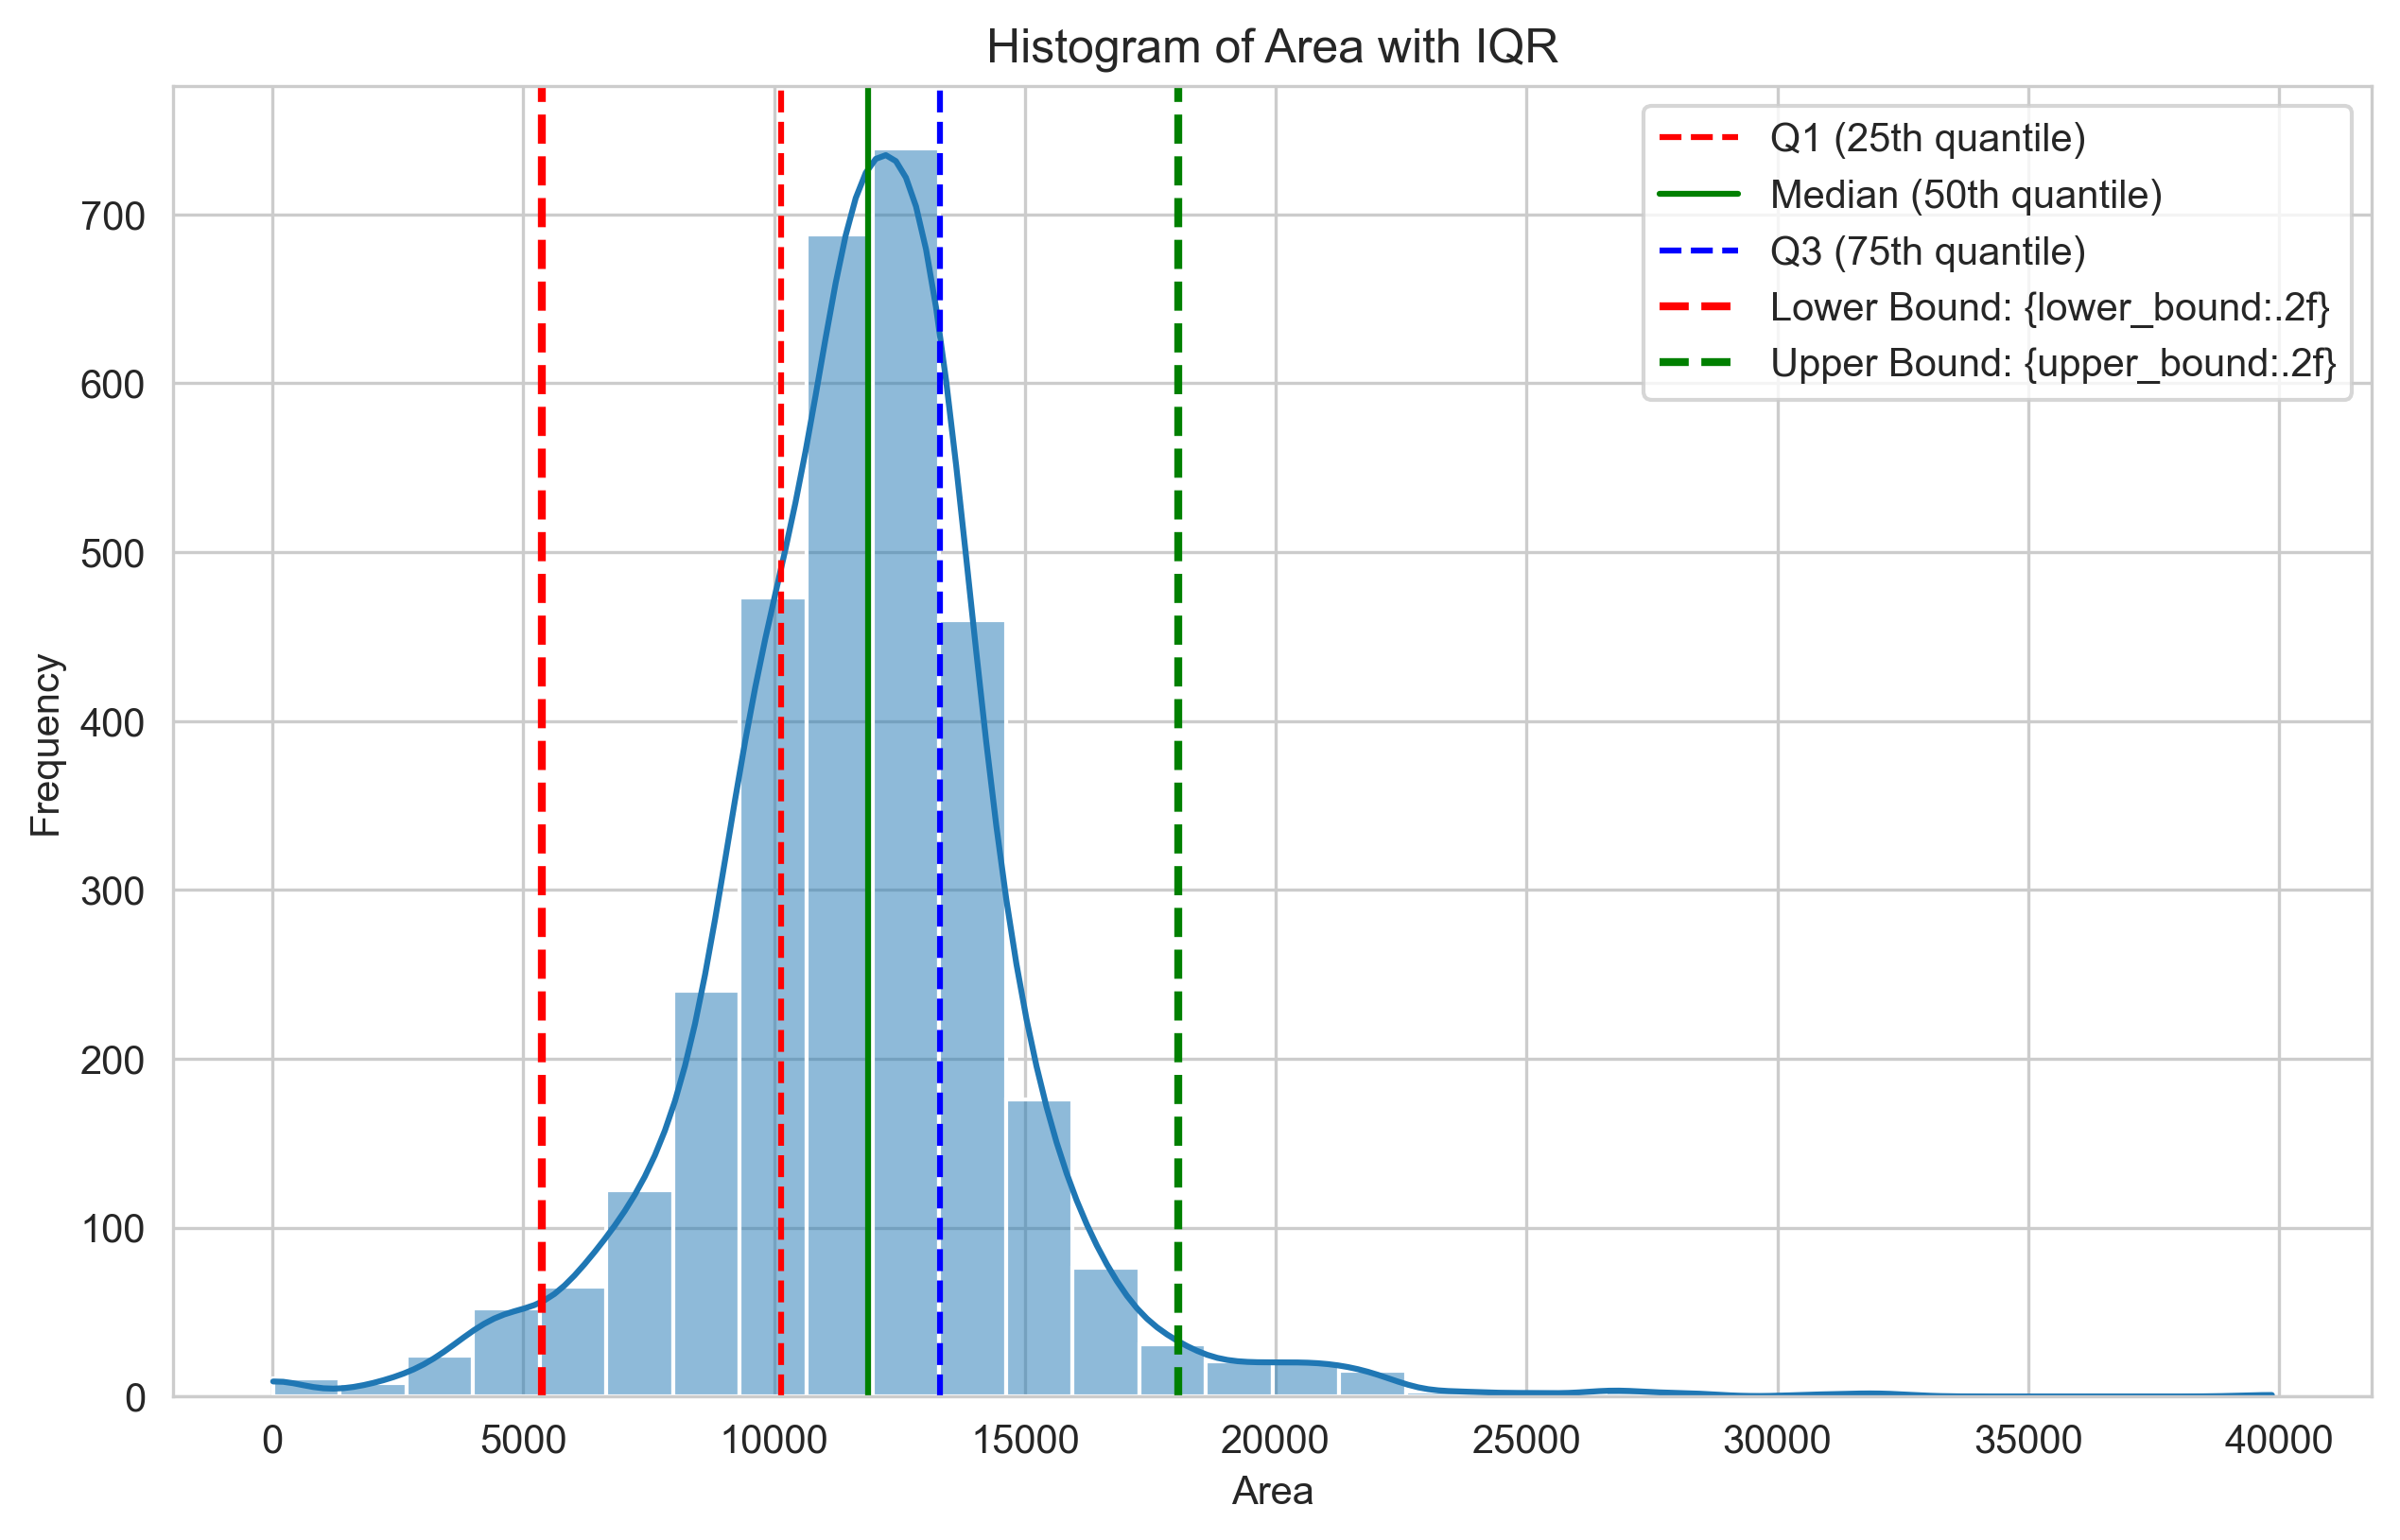

lower_bound =  5380.0
upper_bound =  18056.0


In [19]:
## Checking up on the Area...

import matplotlib.pyplot as plt
import seaborn as sns

dfResult = pd.read_csv("/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/age/output_metrics/20231107_allAges.csv")

Q1 = dfResult['area'].quantile(0.25)
Q3 = dfResult['area'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Plotting histogram for the 'area' column in dfResult
plt.figure(figsize=(10, 6))
sns.histplot(dfResult['area'], kde=True, bins=30)
plt.axvline(Q1, color='r', linestyle='--', label='Q1 (25th quantile)')
plt.axvline(dfResult['area'].median(), color='g', linestyle='-', label='Median (50th quantile)')
plt.axvline(Q3, color='b', linestyle='--', label='Q3 (75th quantile)')
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2, label=f"Lower Bound: {{lower_bound:.2f}}")
plt.axvline(upper_bound, color='green', linestyle='dashed', linewidth=2, label=f"Upper Bound: {{upper_bound:.2f}}")
plt.legend()
plt.title('Histogram of Area with IQR')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("lower_bound = ", lower_bound)
print("upper_bound = ", upper_bound)

In [35]:
### post-processing df for plotting for age timecourse nuclei

import pandas as pd
import re

# Extract age
def extract_age(filename):
    if re.search(r'52week|52wk|1year|1yo', filename):
        return 52
    elif re.search(r'24week|6mo', filename):
        return 24
    elif re.search(r'12week|12wk', filename):
        return 12
    elif re.search(r'7wk', filename):
        return 7
    else:
        return None

# Extract sex
def extract_sex(filename):
    match = re.search(r'(Male|Female)', filename)
    return match.group(1) if match else None

# Extract animal
def extract_animal(filename):
    match = re.search(r'(Male|Female)(\d+)', filename)
    return match.group(2) if match else None

# Extract location
def extract_location(filename):
    match = re.search(r'(Arch|Desc)', filename)
    return match.group(1) if match else None

# Extract image number
def extract_image_number(filename):
    match = re.search(r'60x_(\d)', filename)
    return match.group(1) if match else None

# Apply functions to dataframe
dfResult['age'] = dfResult['file'].apply(extract_age)
dfResult['sex'] = dfResult['file'].apply(extract_sex)
dfResult['animal'] = dfResult['file'].apply(extract_animal)
dfResult['location'] = dfResult['file'].apply(extract_location)
dfResult['imageNumber'] = dfResult['file'].apply(extract_image_number)

print(dfResult)

dfResult.to_csv(os.path.join(savePath, "20231027_allAges_orientationCorrected_02.csv"), index = False)



                                                 file  label     area  \
0   /Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Co...      5  12878.0   
1   /Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Co...      6  10296.0   
2   /Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Co...      7  11849.0   
3   /Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Co...      8  11412.0   
4   /Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Co...      9  12843.0   
..                                                ...    ...      ...   
7   /Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Co...     11  10291.0   
8   /Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Co...     13  12762.0   
9   /Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Co...     15  11632.0   
10  /Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Co...     16  13596.0   
11  /Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Co...     17  11478.0   

     perimeter  centroid-0  centroid-1  major_axis_length  minor_axis_length  \
0   602.558441  115.122768  138.260134     

In [213]:
dfResult.to_csv(os.path.join(savePath, "20230829_artNucMetricResults.csv"), index = False)

In [169]:
import numpy as np
import math
from skimage.measure import regionprops_table
from skimage.morphology import convex_hull_image


### OLD

In [203]:
### post-processing df for plotting for weird and elliptical nuclei

# Extract values and create new columns
dfResult['type'] = dfResult['file'].str.extract(r'\/([^/]+)_\d+_\d+\.tif$')
dfResult['image'] = dfResult['file'].str.extract(r'_(\d+)_\d+\.tif$')
dfResult['n'] = dfResult['file'].str.extract(r'_\d+_(\d+)\.tif$')

# Convert columns to appropriate data types
dfResult['image'] = dfResult['image'].astype(int)
dfResult['n'] = dfResult['n'].astype(int)

#dfResult.to_csv(os.path.join(savePath, "20230828_ctrlNucMetricResults_functionalized3.csv"), index = False)

In [212]:
### post-processing df for plotting for bezier spline generated nuclei

# Extract values and create new columns
dfResult['n'] = dfResult['file'].str.extract(r'n(\d+)_')
dfResult['rad'] = dfResult['file'].str.extract(r'rad(\d+\.\d+)_')
dfResult['edgy'] = dfResult['file'].str.extract(r'edgy(\d+\.\d+)_')
dfResult['id'] = dfResult['file'].str.extract(r'_(\d+)\_gaussianBlur')

# Convert columns to appropriate data types
dfResult['n'] = dfResult['n'].astype(int)
dfResult['rad'] = dfResult['rad'].astype(float)
dfResult['edgy'] = dfResult['edgy'].astype(float)
dfResult['id'] = dfResult['id'].astype(int)

# Display the updated DataFrame
print(dfResult)

                                                 file  label  area  \
0   /Users/mem3579/dataspell/nucleidysmorphia/cont...      1   407   
0   /Users/mem3579/dataspell/nucleidysmorphia/cont...      1   207   
0   /Users/mem3579/dataspell/nucleidysmorphia/cont...      1   401   
0   /Users/mem3579/dataspell/nucleidysmorphia/cont...      1    90   
0   /Users/mem3579/dataspell/nucleidysmorphia/cont...      1   361   
..                                                ...    ...   ...   
0   /Users/mem3579/dataspell/nucleidysmorphia/cont...      1   282   
0   /Users/mem3579/dataspell/nucleidysmorphia/cont...      1   481   
0   /Users/mem3579/dataspell/nucleidysmorphia/cont...      1   569   
0   /Users/mem3579/dataspell/nucleidysmorphia/cont...      1   442   
0   /Users/mem3579/dataspell/nucleidysmorphia/cont...      1   467   

     perimeter  centroid-0  centroid-1  major_axis_length  minor_axis_length  \
0   467.060967  159.534398  247.671990         231.679603         114.271887   

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from math import log

def getCorrelationDimension(binary_image, threshold_distance):
    binary_array = np.array(binary_image)
    labeled_image = label(binary_array)
    regions = regionprops(labeled_image)
    image_height, image_width = binary_array.shape

    # Generate a list of distances between pairs of points
    distances = []
    for reg in regions:
        points = np.argwhere(reg.image)
        num_points = points.shape[0]
        for i in range(num_points):
            for j in range(i + 1, num_points):
                dist = np.linalg.norm(points[i] - points[j])
                distances.append(dist)

    distances = np.array(distances)

    # Calculate the correlation integral for different distance thresholds
    correlation_counts = []
    for dist_threshold in distances:
        num_pairs_within_threshold = np.sum(distances <= dist_threshold)
        correlation_counts.append(num_pairs_within_threshold)

    correlation_counts = np.array(correlation_counts)

    # Calculate the correlation dimension using linear regression
    valid_indices = np.where(correlation_counts > 0)
    coeffs = np.polyfit(np.log(distances[valid_indices]), np.log(correlation_counts[valid_indices]), 1)

    correlation_dimension = coeffs[0]

    return correlation_dimension

if __name__ == "__main__":
    # Load your binary image here
    binary_image = Image.open("/Users/mem3579/dataspell/nucleidysmorphia/controls/artificial/artNucs/artNuc_n15_rad0.50_edgy0.50_070.tif")

    threshold_distance = 10  # Adjust as needed
    corr_dim = getCorrelationDimension(binary_image, threshold_distance)

    print("Correlation Dimension:", corr_dim)

KeyboardInterrupt: 

In [ ]:
# wadell roundness MOVED 20230901

def compute_wadell_roundness(equivalent_diameter_area, df_distance):
    # Compute the radius of the largest inscribed disk (R)
    R = equivalent_diameter_area / (2 * np.pi)

    # Compute the radii of curvature at each pixel on the boundary (r_i)
    r_i = df_distance.groupby('label')['distance'].mean().values

    # Compute the number of radii of curvature smaller than or equal to R (k)
    k = np.sum(r_i <= R)

    # Compute the Wadell roundness (Rw)
    wadell_roundness = (1 / (k * R)) * np.sum(r_i)

    return wadell_roundness

In [ ]:
# main function MOVED 20230901

def main(files):
    dfResult = pd.DataFrame()

    for file in files:

        masksArray, outlines, contours, minkowskiDimension = pre_process(file)

        if masksArray is None:
            continue

        # Load the .tif images and make it into a binary image (label) so that regionprops can measure it
        props = measure.regionprops_table(outlines, properties=['label',
                                                                'area',
                                                                'perimeter',                #3
                                                                'centroid',                 #4
                                                                'major_axis_length',        #5
                                                                'minor_axis_length',        #6
                                                                'eccentricity',             #7
                                                                'solidity',                 #8
                                                                'euler_number',             #9
                                                                'equivalent_diameter_area', #10
                                                                'area_bbox',                #11
                                                                'area_convex',              #12
                                                                'area_filled',              #13
                                                                'extent',                   #14
                                                                'feret_diameter_max',       #15
                                                                'perimeter_crofton'])       #16


        df_props = pd.DataFrame(props)

        df_props.insert(0, 'file', file)

        # To correct for 0.5 pixel offset between the center of pixel and pixel corners
        # mentioned in the regionprops documentation: https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops_table
        df_props['centroid-0'] += 0.5
        df_props['centroid-1'] += 0.5

        df_distance = calculate_distances(outlines, df_props)
        r_avgs, rms_avgs, r_diffs, minkowskiDimensions = calculate_rms_avgs(df_distance, minkowskiDimension)

        # Update df_distance with 'r_diff' column
        df_distance['r_diff'] = r_diffs

        df_bin_avg, df_intercept = calculate_x_intercepts(df_distance)
        df_rmssub = calculate_rms_diff(df_distance)
        concav = calculate_concavity_ct(df_distance)

        masksArray = masksArray.astype(np.uint8)
        convex_areas = compute_convex_area(masksArray)

        # Update df_props
        df_props['r_avg'] = r_avgs
        df_props['rms_avg'] = rms_avgs
        df_props['minkowskiDimension'] = minkowskiDimensions
        df_props['x_intercepts'] = df_intercept.groupby('label').size().tolist()
        df_props['rms_subsampled'] = df_rmssub['rms'].values.tolist()
        df_props['concavity_ct'] = list(concav)
        df_props['convex_area'] = convex_areas
        #df_props['wadell_roundness'] = compute_wadell_roundness(df_props['equivalent_diameter_area'], df_distance)

        # calculations of new metrics
        df_props['circularity'] = 4 * np.pi * df_props.loc[:, 'area'] / (df_props.loc[:, 'perimeter'] ** 2) #aka Shape Factor
        df_props['compactness'] = df_props['area'] / df_props['perimeter']**2
        df_props['roundness'] = df_props['area'] / (math.pi * (df_props['perimeter'] / (2*math.pi))**2)
        df_props['convexity'] = df_props['perimeter'] / df_props['convex_area']
        df_props['aspect_ratio'] = df_props['major_axis_length'] / df_props['minor_axis_length']
        df_props['form_factor'] = df_props['area'] / df_props['equivalent_diameter_area']**2

        convex_areas = compute_convex_area(masksArray)
        df_props['convex_area'] = convex_areas

        # Concatenate results
        dfResult = pd.concat([dfResult, df_props])

    return dfResult



In [ ]:
# getting .tif to .npy format :(
from PIL import Image
import numpy as np

files = glob.glob(f"{dataPath}/*.tif")

data = []

for file in files:
    tif_image = Image.open(file)
    tif_image = tif_image.convert("L")
    tif_array = np.array(tif_image)
    threshold_value = 128
    binary_image = (tif_array > threshold_value).astype(np.uint8) * 255
    data.concat(binary_image)

len(data)

In [ ]:
# FOR ARTIFICIAL NUCLEI IN .tif FORMAT ---- NOT SEGMENTED .npy FILES!

## Getting properties of nuclei

from skimage import measure
from skimage.measure import label
from skimage.segmentation import find_boundaries

dataPath = "/Users/mem3579/dataspell/nucleidysmorphia/controls/combined/segmented/individuals/"

files = glob.glob(f"{dataPath}/*.tif")

dfResult = pd.DataFrame()
for file in files:

    masks = Image.open(file)

    # Convert the Pillow image to a NumPy array
    masksArray = np.array(masks)

    if np.all(masksArray == 0):
        print(f"Skipping {file} because it has no mask signal")
        continue

    #getting minkowski-Bouligard Dimension, need to do so from full image.
    #if np.any(masksArray != 0):
    minkowskiDimension = getminkowskidimension(masks)
    #else:
    #minkowskiDimension = 0


    # Find the contours (outlines) in the binary mask
    contours = measure.find_contours(masksArray, 0.5)  # 0.5 is the contour level threshold

    # Create a blank image with the same shape as the original binary mask
    outlines = np.zeros_like(masksArray)


    # Set the contour coordinates to 1 in the outline image
    for contour in contours:
        contour = np.around(contour).astype(int)
        outlines[contour[:, 0], contour[:, 1]] = 1

    distance_data = []
    #masks = np.array(file)
    #masks = measure.label(masks, connectivity=2, return_num=True)
    #outlines = find_boundaries(masks)
    outlines = outlines.astype(np.uint8)

    # Load the .tif images and make it into a binary image (label) so that regionprops can measure it
    props = measure.regionprops_table(outlines, properties=['label',                    #1
                                                            'area',                     #2
                                                            'perimeter',                #3
                                                            'centroid',                 #4
                                                            'major_axis_length',        #5
                                                            'minor_axis_length',        #6
                                                            'eccentricity',             #7
                                                            'solidity',                 #8
                                                            'euler_number',             #9
                                                            'equivalent_diameter_area', #10
                                                            'area_bbox',                #11
                                                            'area_convex',              #12
                                                            'area_filled',              #13
                                                            'extent',                   #14
                                                            'feret_diameter_max',       #15
                                                            'perimeter_crofton'])       #16

    # Convert props to DataFrame
    df_props = pd.DataFrame(props)

    df_props.insert(0, 'file', file)

    for index, row in df_props.iterrows():
        centroid_x = row['centroid-1']
        centroid_y = row['centroid-0'] #'centroid-0' is y and 'centroid-1'is x
        semi_major = row['major_axis_length']/2
        semi_minor = row['minor_axis_length']/2
        label = index

        coord = np.where(outlines == 1) ## THIS needs to be OUTLINES because you only want to look at only the peripheral pixels to calculate the radii

        for i in range(len(coord[0])):
            outline_x = coord[1][i]
            outline_y = coord[0][i]

            r = math.dist((outline_y, outline_x), (centroid_y, centroid_x))
            theta = math.atan2((outline_y - centroid_y), (outline_x - centroid_x))

            r_norm = (semi_major*semi_minor)/(math.sqrt(((semi_major**2) * (math.sin(theta))**2) + ((semi_minor**2) * (math.cos(theta))**2)))
            r_rms = math.sqrt(abs((r**2)-(r_norm**2)))

            distance_data.append([row['label'],
                                  centroid_x,
                                  centroid_y,
                                  outline_x,
                                  outline_y,
                                  theta,
                                  r,
                                  r_norm,
                                  r_rms,
                                  row['major_axis_length'],
                                  row['minor_axis_length']])

    df_distance = pd.DataFrame(distance_data, columns=['label',
                                                       'centroid_x',
                                                       'centroid_y',
                                                       'outline_x',
                                                       'outline_y',
                                                       'theta',
                                                       'r',
                                                       'r_norm',
                                                       'r_rms',
                                                       'major_axis_length',
                                                       'minor_axis_length'])

    #print("df_distance:", df_distance) # to check the values

    r_avgs = []
    rms_avgs = []
    r_diffs  = []
    minkowskiDimensions = []

    for label in np.unique(df_distance['label']):
        r_avg = df_distance.loc[df_distance['label']==label, 'r_norm'].mean()
        r_avgs.append(r_avg)

        rms_avg = df_distance.loc[df_distance['label']==label, 'r_rms'].mean()
        rms_avgs.append(rms_avg)

        minkowskiDimensions.append(minkowskiDimension)



        for i, row in df_distance[df_distance['label']==label].iterrows():
            r_diff = row['r'] - r_avg
            r_diffs.append(r_diff)

    df_distance['r_avg'] = [r_avgs[i] for i in (df_distance['label'] - 1).astype(int)]
    df_distance['r_diff'] = r_diffs
    df_distance['rms_avg'] = [rms_avgs[i] for i in (df_distance['label'] - 1).astype(int)]

    df_props['r_avg'] = r_avgs
    df_props['rms_avg'] = rms_avgs
    df_props['minkowskiDimension'] = minkowskiDimensions

    # NIM1 finish:

    df_bin_avg = pd.DataFrame()

    for label in np.unique(df_distance['label']):
        df_label = df_distance[df_distance['label'] == label].copy()
        df_label['theta_bin'] = pd.cut(df_label['theta'], np.arange(-np.pi, np.pi, 0.1), right= True)
        grouped = df_label.groupby('theta_bin')

        for theta_bin, group in grouped:
            r_diff_bin = group['r_diff'].mean()

            new_data = {'label': label, 'bin': theta_bin, 'r_diff_bin': r_diff_bin}
            df_bin_avg = pd.concat([df_bin_avg, pd.DataFrame([new_data])], ignore_index=True)


    df_bin_avg['sign_change'] = np.sign(df_bin_avg['r_diff_bin']).diff().ne(0).astype(int)

    df_intercept = df_bin_avg[df_bin_avg['sign_change'] != 0]

    df_props['x-intercepts'] = df_intercept.groupby('label').size().tolist()

    # NIM2 finish, subsampling

    subsample_size = 50

    df_rmssub = pd.DataFrame(columns=['label', 'rms'])

    for label in np.unique(df_distance['label']):
        df_label = df_distance[df_distance['label'] == label].sort_values('theta')
        num_points = len(df_label)

        if num_points > subsample_size:
            theta_points = np.arange(num_points)[::int(num_points/subsample_size)]
            rms_values = df_label.iloc[theta_points]['r_rms'].values
            rms_sub_avg = np.average(rms_values)

        else:
            rms_sub_avg = np.nan

        new_row = pd.DataFrame({'rms': [rms_sub_avg]})
        df_rmssub = pd.concat([df_rmssub, new_row], ignore_index=True)


    df_props['rms_subsampled'] = df_rmssub['rms'].values.tolist()

    # NIM3 Concavity

    concavity_ct = {}

    for label in np.unique(df_distance['label']):
        concavity_ct[label] = 0
        theta_vals = np.unique(df_distance.loc[df_distance['label']==label, 'theta'])

        for theta in theta_vals:
            r_vals = df_distance.loc[(df_distance['label' ]== label) &
                                     (df_distance['theta'] >= theta-0.002) &
                                     (df_distance['theta'] <= theta+0.002), 'r'].unique()

            if len(r_vals) > 1:
                concavity_ct[label] += 1

    concav = [v[1] if isinstance(v, tuple) else v for v in concavity_ct.values()]

    df_props['concavity_ct'] = list(concav)

    dfResult = pd.concat([dfResult, df_props])

In [ ]:
# comparing big block of metrics vs functionalized metric values (20230828):

# Load the data
file1 = '/Users/mem3579/dataspell/nucleidysmorphia/controls/artificial/output/20230815_ctrlNucMetricResults.csv'
file2 = '/Users/mem3579/dataspell/nucleidysmorphia/controls/artificial/output/20230828_ctrlNucMetricResults_functionalized.csv'

data1 = pd.read_csv(file1)
data1 = data1.iloc[:, :-3]


data2 = pd.read_csv(file2)

differences = data1.compare(data2)

print(differences)

#note: no differences!!

In [ ]:
# FOR SEGMENTED IMAGE .npy FILES!

### note: moved to "old" 20230828, not sure if i will need this in the future- i have been working with .tif files only... will try to continue this way when i start to segment independently.

## Getting properties of nuclei

dfResult = pd.DataFrame()

for file in files:

    distance_data = []

    masks = np.load(file, allow_pickle = True).item()['masks']
    outlines = np.load(file, allow_pickle = True).item()['outlines']
    props = measure.regionprops_table(masks, properties=['label',
                                                         'area',
                                                         'perimeter',
                                                         'centroid',
                                                         'major_axis_length',
                                                         'minor_axis_length',
                                                         'eccentricity'])

    df_props = pd.DataFrame(props)
    df_props.insert(0, 'file', file)

    for index, row in df_props.iterrows():
        centroid_y = row['centroid-0'] #'centroid-0' is y and 'centroid-1'is x
        centroid_x = row['centroid-1']
        semi_major = row['major_axis_length']/2
        semi_minor = row['minor_axis_length']/2
        label = row['label']

        coord = np.where(outlines == label)

        for i in range(len(coord[0])):
            outline_x = coord[1][i]
            outline_y = coord[0][i]
            r = math.dist((outline_y, outline_x), (centroid_y, centroid_x))
            theta = math.atan2((outline_y - centroid_y), (outline_x - centroid_x))
            r_norm = (semi_major*semi_minor)/(math.sqrt(((semi_major**2) * (math.sin(theta))**2) + ((semi_minor**2) * (math.cos(theta))**2)))

            r_rms = math.sqrt(abs((r**2)-(r_norm**2)))

            distance_data.concat([row['label'],
                                  centroid_x,
                                  centroid_y,
                                  outline_x,
                                  outline_y,
                                  theta,
                                  r,
                                  r_norm,
                                  r_rms,
                                  row['major_axis_length'],
                                  row['minor_axis_length']])

    df_distance = pd.DataFrame(distance_data, columns=['label',
                                                       'centroid_x',
                                                       'centroid_y',
                                                       'outline_x',
                                                       'outline_y',
                                                       'theta',
                                                       'r',
                                                       'r_norm',
                                                       'r_rms',
                                                       'major_axis_length',
                                                       'minor_axis_length'])
    # NIM 1 prelim and NIM2 avgs

    r_avgs = []
    rms_avgs = []
    r_diffs  = []

    for label in np.unique(df_distance['label']):
        r_avg = df_distance.loc[df_distance['label']==label, 'r_norm'].mean()
        rms_avg = df_distance.loc[df_distance['label']==label, 'r_rms'].mean()

        r_avgs.concat(r_avg)
        rms_avgs.concat(rms_avg)

        for i, row in df_distance[df_distance['label']==label].iterrows():
            r_diff = row['r'] - r_avg
            r_diffs.append(r_diff)



    df_distance['r_avg'] = [r_avgs[i] for i in (df_distance['label'] - 1).astype(int)]
    df_distance['r_diff'] = r_diffs
    df_distance['rms_avg'] = [rms_avgs[i] for i in (df_distance['label'] - 1).astype(int)]

    df_props['r_avg'] = r_avgs
    df_props['rms_avg'] = rms_avgs

    # NIM1 finish:

    df_bin_avg = pd.DataFrame()

    for label in np.unique(df_distance['label']):
        df_label = df_distance[df_distance['label'] == label].copy()
        df_label['theta_bin'] = pd.cut(df_label['theta'], np.arange(-np.pi, np.pi, 0.1), right= True)
        grouped = df_label.groupby('theta_bin')

        for theta_bin, group in grouped:
            r_diff_bin = group['r_diff'].mean()
            df_bin_avg = df_bin_avg.concat({'label': label, 'bin': theta_bin, 'r_diff_bin': r_diff_bin}, ignore_index=True)

    df_bin_avg['sign_change'] = np.sign(df_bin_avg['r_diff_bin']).diff().ne(0).astype(int)

    df_intercept = df_bin_avg[df_bin_avg['sign_change'] != 0]

    df_props['x-intercepts'] = df_intercept.groupby('label').size().tolist()

    # NIM2 finish, subsampling

    subsample_size = 50

    df_rmssub = pd.DataFrame(columns=['label', 'rms'])

    for label in np.unique(df_distance['label']):
        df_label = df_distance[df_distance['label'] == label].sort_values('theta')
        num_points = len(df_label)

        if num_points > subsample_size:
            theta_points = np.arange(num_points)[::int(num_points/subsample_size)]
            rms_values = df_label.iloc[theta_points]['r_rms'].values
            rms_sub_avg = np.average(rms_values)

        else:
            rms_sub_avg = np.nan

        df_rmssub = df_rmssub.concat({'rms': rms_sub_avg}, ignore_index=True)


    df_props['rms_subsampled'] = df_rmssub['rms'].values.tolist()

    # NIM3 Concavity

    concavity_ct = {}

    for label in np.unique(df_distance['label']):
        concavity_ct[label] = 0
        theta_vals = np.unique(df_distance.loc[df_distance['label']==label, 'theta'])

        for theta in theta_vals:
            r_vals = df_distance.loc[(df_distance['label' ]== label) &
                                     (df_distance['theta'] >= theta-0.002) &
                                     (df_distance['theta'] <= theta+0.002), 'r'].unique()

            if len(r_vals) > 1:
                concavity_ct[label] += 1

    concav = [v[1] if isinstance(v, tuple) else v for v in concavity_ct.values()]

    df_props['concavity_ct'] = list(concav)

    dfResult = pd.concat([dfResult, df_props])

    #df_props.to_csv(file + "_props_20230223.csv", index=False)

#dfResult.to_csv(os.path.join(savePath, "artificialMetrics.csv"), index = False)